# Local Homology Protein Sequence Analysis: unsupervised motif disambiguation

This is based on the Natural Language Processing [(NLP) Notebook](https://github.com/giotto-ai/giotto-tda/blob/master/examples/local_hom_NLP_disambiguation.ipynb) and the paper [Topology of Word Embeddings: Singularities Reflect Polysemy](https://arxiv.org/abs/2011.09413). However, in place of word embedding we use the internal representations of ESM-2 (hidden states of layers). So, this turns out to be a model interpretability and analysis technique, as well as a motif function disambiguation technique. In particular, this work is related to [Intrinsic Dimension Estimation for Robust Detection of AI-Generated Texts](https://arxiv.org/abs/2306.04723). It is not yet clear how well the technique transfers over to prtein sequences, but this notebook should serve as a starting point for investigating this. 

In this tutorial, we apply local homology to study protein sequence data. We showcase how to use local homology to disambiguate sequential motifs. In particular, we focus our analysis to disambiguate a specific motif, which can have different functional implications depending on its context within the protein sequence. If you are looking at a static version of this notebook and would like to run its contents, head over to GitHub and download the source.

## See also
[Topological feature extraction using VietorisRipsPersistence and PersistenceEntropy](https://giotto-ai.github.io/gtda-docs/latest/notebooks/vietoris_rips_quickstart.html) for a quick introduction to general topological feature extraction in giotto-tda. [Local Homology](https://github.com/giotto-ai/giotto-tda/blob/master/examples/local_homology.ipynb), in which Giotto-TDA introduces the `RadiusLocalVietorisRips` and `KNeighborsLocalVietorisRips` "transformers" used here are introduced. This should not be confused with the Transformer architecture of ESM-2, which we will be using in this notebook as well. 

## The context
Most modern machine learning techniques dealing with protein sequence data need to preprocess these sequences and transform them into more standard objects: arrays. The process of transforming a protein sequence into an array is done through the use of protein embeddings.

The disadvantage of most embedding techniques is that the same sequential motif is mapped to the same array. Hence, if two motifs have the same sequence but different functional implications, such motifs will anyway be mapped to the same array! Unless of course we are working with latent embeddings that take context into account, such as those found in transformers (protein language models). In this case, the *context vectors* associated to motifs will change depending on their context. However, the manifold that the context vectors lie on may still have a singular locus and the values of the context vectors may not change very much depending on the quality of the protein language model, the particular attention head or layer used to compute the latent representation of the motif of interest, and depending on the motif itself. Some motifs may lie on smooth regions, while others may be highly singular. Determining properties of the embedding manifold given by the hidden states of a layer of ESM-2 is similar to the work in NLP mentioned above. We note in particular this has applications to protein topic modeling using [ESMTopic](https://github.com/Amelie-Schreiber/transformers_proteins_and_persistent_homology), as well as model interpretability where the topology and Hausdorff dimension of the embedding manifold are important to study. 

## The task
Given the above introduction, our task is to disambiguate sequential motifs, i.e., finding a way to differentiate motifs by their functional implications. Our approach consists of analysing the whole protein sequence in which the motif appears and try to deduce the function of the motif from its context (i.e., neighbouring amino acids). The core idea of our proposal is based on the algebraic topology description of the space of protein embeddings. 

## The main idea
We are structuring our analysis on the assumptions that are clearly explained in [Topology of Word Embeddings: Singularities Reflect Polysemy](https://arxiv.org/abs/2011.09413). In a few words, the idea is that a sequential motif with multiple functional implications sits on the singular loci of the stratified space of the protein embeddings. This sentence is in truth not formally correct, as there is yet no clear notion of what is the canonical topology in the protein embedding space; nonetheless, the intuition behind these concepts can be explained pictorially:

<div style="text-align:center">
    <img src="disambiguation.png" alt="Word Manifold" width="500"/>
</div>

This picture represents the local shape of the word-embedding space: the context words are located over the four cones tipping at the word mole (the singularity). Hence, a sentence from a thriller containing the word mole would most probably be located on the north-west branch, and so on.

This picture could also represent the local shape of the protein-embedding space: the contextual amino acids are located over the four cones tipping at the specific motif (the singularity). Hence, a sequence from a protein involved in a particular biological process containing the motif would most probably be located on the north-west branch, and so on.

## The goal of our exploration

We would first like to stress that this notebook is merely exploratory and that there is no aim at making it a fully-fledged ML pipeline for motif disambiguation. We would really like to understand if the shape of the cones around the singularity (i.e., the motif point) can be distinguished with local homology: if that is the case, then the geometric shape of a protein sequence lying on the protein embedding stratified space correlates with the function of a motif! This entails a new disambiguation technique.

In [122]:
!pip install numpy==1.24.0 -q
!pip install numba -q
!pip install umap-learn -q
!pip install giotto-tda -q
!pip install gensim -q
!pip install transformers -q
!pip install torch


In [123]:
# Import PyData libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline, Pipeline

# Import umap for dimensionality reduction and visualization
# umap-learn is not a requirement of giotto-tda, but is needed here.
from umap import UMAP

# giotto-tda imports
from gtda.plotting import plot_point_cloud
from gtda.local_homology import KNeighborsLocalVietorisRips
from gtda.diagrams import PersistenceEntropy

## The dataset and its preprocessing
The dataset contains many occurrences of the motif with the function lying on some manifold which potentially has a singularity if the motif has multiple functions in different contexts. Note, the functional roles below have not been checked and the protein sequences are synthetic, generated by GPT-4. 

In [124]:
# First, let's create a file with thirty protein sequences, each with a common sequential motif.

# Define the common sequential motif
motif = "KRKCGHLG"

# Define the rest of the protein sequences
proteins = [
# The motif acts as a binding site
"ADKERKCGHLGHTLFSYKLLGKDTVAATGRVLQAIDGKMFSKC" + "KRKCGHLG" + "DKS", # Binding site
"MDFLKRKCGHLGTPQQVKKERLKCGHMGMNVFGQKYTLAAALM" + "KRKCGHLG" + "RD", # Binding site
"TVASQKRKCGHLGTWISGDLFTKAKVQLIKCGHLGVNVVLGDQT" + "KRKCGHLG" + "AI", # Binding site
"DDFQKRKCGHLGSFRYIQAVKAKKQARLKCGHMGMNKITMFFRL" + "KRKCGHLG" + "TK", # Binding site
"VFLGKRKCGHLGKRARLAAVQMLKKRKCGHMGMLSGVFKRKCGH" + "KRKCGHLG" + "QR", # Binding site
"GIGGRKRKCGHLGGMIKQIRATGKAKFLLKCGHLGVIVLSGP" + "KRKCGHLG" + "MG", # Binding site

# The motif acts as a catalytic site
"ATGVLKRKCGHLGVALWSTLQILKCGHMGARVTAYGGFATKRKCG" + "KRKCGHLG" + "AQT", # Catalytic site
"QQALKRKCGHLGVTIVTQGVSQTKRKCGHMGRKAGIDFDKRKCG" + "KRKCGHLG" + "AAL", # Catalytic site
"FTYSQKRKCGHLGQITGAGSARLKCGHMGMQALGKTTKRKCGH" + "KRKCGHLG" + "LGK", # Catalytic site
"MDFGKRKCGHLGTPQQVKKERLKCGHMGMNVFGQKYTLAAALMK" + "KRKCGHLG" + "HM", # Catalytic site
"TVAVRKCGHLGKWISGDLFTKAKVQLIKCGHLGVNVVLGDQTVA" + "KRKCGHLG" + "LAAVI", # Catalytic site
"DDFQKRKCGHLGSFRYIQAVKAKKQARLKCGHMGMNKITMFFRL" + "KRKCGHLG" + "TETKA", # Catalytic site

# The motif acts as a structural component
"VFLGKRKCGHLGKRARLAAVQMLKKRKCGHMGMLSGVFKRKCGH" + "KRKCGHLG" + "MGQS", # Structural component
"GIGGRKRKCGHLGGMIKQIRATGKAKFLLKCGHLGVIVLSGP" + "KRKCGHLG" + "MG", # Structural component
"ATGVLKRKCGHLGVALWSTLQILKCGHMGARVTAYGGFATKRKCG" + "KRKCGHLG" + "AQT", # Structural component
"QQALKRKCGHLGVTIVTQGVSQTKRKCGHMGRKAGIDFDKRKCG" + "KRKCGHLG" + "AAL", # Structural component
"FTYSQKRKCGHLGQITGAGSARLKCGHMGMQALGKTTKRKCGH" + "KRKCGHLG" + "LGK", # Structural component
"ADKERKCGHLGHTLFSYKLLGKDTVAATGRVLQAIDGKMFSKC" + "KRKCGHLG" + "DKS", # Structural component

# The motif acts as a signal peptide
"MDFLKRKCGHLGTPQQVKKERLKCGHMGMNVFGQKYTLAAALM" + "KRKCGHLG" + "RD", # Signal peptide
"TVASQKRKCGHLGTWISGDLFTKAKVQLIKCGHLGVNVVLGDQT" + "KRKCGHLG" + "AI", # Signal peptide
"DDFQKRKCGHLGSFRYIQAVKAKKQARLKCGHMGMNKITMFFRL" + "KRKCGHLG" + "TK", # Signal peptide
"VFLGKRKCGHLGKRARLAAVQMLKKRKCGHMGMLSGVFKRKCGH" + "KRKCGHLG" + "QR", # Signal peptide
"GIGGRKRKCGHLGGMIKQIRATGKAKFLLKCGHLGVIVLSGP" + "KRKCGHLG" + "MG", # Signal peptide
"ATGVLKRKCGHLGVALWSTLQILKCGHMGARVTAYGGFATKRKCG" + "KRKCGHLG" + "AQT", # Signal peptide

# The motif acts as a cellular localization signal
"QQALKRKCGHLGVTIVTQGVSQTKRKCGHMGRKAGIDFDKRKCG" + "KRKCGHLG" + "AAL", # Localization signal
"FTYSQKRKCGHLGQITGAGSARLKCGHMGMQALGKTTKRKCGH" + "KRKCGHLG" + "LGK", # Localization signal
"MDFGKRKCGHLGTPQQVKKERLKCGHMGMNVFGQKYTLAAALMK" + "KRKCGHLG" + "HM", # Localization signal
"TVAVRKCGHLGKWISGDLFTKAKVQLIKCGHLGVNVVLGDQTVA" + "KRKCGHLG" + "LAAVI", # Localization signal
"DDFQKRKCGHLGSFRYIQAVKAKKQARLKCGHMGMNKITMFFRL" + "KRKCGHLG" + "TETKA", # Localization signal
"VFLGKRKCGHLGKRARLAAVQMLKKRKCGHMGMLSGVFKRKCGH" + "KRKCGHLG" + "QR", # Localization signal

# The motif acts as a binding site
"GYKARKRKCGHLGSATKYLQTGFRRN" + motif + "AKQYTMIGSLA",
"FTLTTRKRKCGHLGSKVAKDLDTKT" + motif + "ASVRGVVSKQI",
"SHKGDKRKCGHLGKGAVGYAIAKKG" + motif + "AAAVRLMGKIY",
"IVKYVFKRKCGHLGGKSMIGRTGTG" + motif + "VAGVRLSVIG",
"KMKQSKRKCGHLGVGATGQSKAGMR" + motif + "GKSVKAGVYR",
"GITKIKRKCGHLGAKGVGKSGKAVG" + motif + "RKGSMVAAGI",

# The motif acts as a catalytic site
"AAGSRKRKCGHLGVGVYAGGAVGKS" + motif + "TGVGYKAVGS",
"SVGKGARKRKCGHLGKGVAGYKGVY" + motif + "AYGVGVKGSI",
"GASKSKRKCGHLGVYKGSVGKVAGY" + motif + "AGYKGASKAV",
"YGVGAARKRKCGHLGGVYGSKAVYK" + motif + "VAGSGKGAVY",
"ASKGGVKRKCGHLGAYKGVAASKVG" + motif + "GAYKGAGASK",
"SVKGARKRKCGHLGVYKAGSVAAGY" + motif + "KAGAYGVASK",

# The motif acts as a structural component
"GKAVSVARKRKCGHLGKSVGVAAGA" + motif + "VKGASKSGAV",
"AYGKGARKRKCGHLGAYKGAVGKSV" + motif + "GVAYKAGSVK",
"GVKGARKRKCGHLGAYAGGVSVGKY" + motif + "KGAYKASKGV",
"SVGARKRKCGHLGKAGVGYAGGVKG" + motif + "KSVGAYGVA",
"AYKGARKRKCGHLGGKVAYAGKSVK" + motif + "YGVGKAGGVA",
"VKGARKRKCGHLGGVYKGVAASKVG" + motif + "GVASKAVAYG",

# The motif acts as a signal peptide
"AYKVARKRKCGHLGKAGSVAGYKGA" + motif + "SGVYKGVAAS",
"SGKGARKRKCGHLGGVYGKSVAYAG" + motif + "VKGASKAGVA",
"GAGVARKRKCGHLGGVYGVKGAYSV" + motif + "SVKAGYGVAS",
"VAGGARKRKCGHLGGVGKVAYSVGA" + motif + "KGVAASKGAY",
"KGAARKRKCGHLGKGVAASKGAYSV" + motif + "AGYAGKVGSV",
"KGARKRKCGHLGVGKGAYAGSVGAV" + motif + "GAYGVKGASK",

# The motif acts as a cellular localization signal
"GAGSVKRKCGHLGGVKGVAYSVGAA" + motif + "AGKAYSVGAG",
"KAGSVKRKCGHLGKGVAAGYGKSVG" + motif + "SVAGKSVGAY",
"GKSVARKRKCGHLGKSVGKAGVGAY" + motif + "AGGVKGAYSV",
"AGSVKRKCGHLGGYKGVGASKAGGV" + motif + "KGAYSVGKGV",
"GVKRKCGHLGAYGVKGAGSVGAYGV" + motif + "SVKAGSVGKY",
"AGKRKCGHLGVAYGKSVGKVAYGVG" + motif + "GASKVAYGVK"
]



# Write the protein sequences to a file
with open("protein_sequences.txt", "w") as f:
    for protein in proteins:
        f.write(protein + "\n")


In [125]:
# Preprocess the data
with open("protein_sequences.txt", "r") as f:
    content = f.read()

# Split the protein sequences
proteins = content.split("\n")

# Now proteins is a list of protein sequences

Next, we extract sequences from our corpus and vectorize their words using the hidden states of a layer of ESM-2:

In [126]:
class PreprocessProteins(BaseEstimator, TransformerMixin):
    """A class to transform a list of protein sequences into a list of model output tensors"""
    def __init__(self):
        self.tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
        self.model = EsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D", output_hidden_states=True)

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None, layer=-1):
        list_of_outputs = []
        for sequence in X:
            inputs = self.tokenizer(sequence, return_tensors="pt")
            outputs = self.model(**inputs)
            hidden_states = outputs.hidden_states[layer].detach()  # Detach the tensor before storing it
            hidden_states_2d = hidden_states[0].numpy()  # Convert to 2D numpy array
            list_of_outputs.append(hidden_states_2d)
        return list_of_outputs


In [127]:
from transformers import AutoTokenizer, EsmModel
import torch

tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
model = EsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D")

pp = PreprocessProteins()
list_of_model_outputs = pp.transform(proteins, layer=6)  # all model outputs for each protein sequence from the first layer


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## The exploratory results
Here below we see a couple of sentences containing the word "note" with the different meanings described above.

In [128]:
print(f"""Example of the first preprocessed protein sequence:
proteins[0] = {proteins[0]}

Example of the second preprocessed protein sequence:
proteins[1] = {proteins[1]}""")


Example of the first preprocessed protein sequence:
proteins[0] = ADKERKCGHLGHTLFSYKLLGKDTVAATGRVLQAIDGKMFSKCKRKCGHLGDKS

Example of the second preprocessed protein sequence:
proteins[1] = MDFLKRKCGHLGTPQQVKKERLKCGHMGMNVFGQKYTLAAALMKRKCGHLGRD


## Local homology pipeline
As explained in Topological feature extraction using VietorisRipsPersistence and PersistenceEntropy, "persistence diagrams" are a common and useful way to store information about the topology and geometry of data. Their content can be summarized and made interpretable even further by means of a variety of featurization methods.

We will use a similar topological feature extraction method as in the Local Homology notebook, and apply it to our Word2Vec embeddings! In particular, we will fit our local homology transformer on either of the example sentences above (seen as point clouds of word vectors) and transform it on the fixed Word2Vec embedding for the word "note", to see if any topological differences arise.

In [129]:
# Initialize a `KNeighborsLocalVietorisRips` local homology transformer.
n_neighbors = (5, 15)
homology_dimensions = (0, 1)
collapse_edges = True
n_jobs = -1
kn_lh = KNeighborsLocalVietorisRips(n_neighbors=n_neighbors,
                                    homology_dimensions=homology_dimensions,
                                    collapse_edges=collapse_edges,
                                    n_jobs=n_jobs)

# Define a featurization method for persistence diagrams.
mod_pe =  make_pipeline(PersistenceEntropy(),
                        FunctionTransformer(func=lambda X: 2 ** X))

# Fit the local homology transformer on the hidden states of the first protein, 
# and apply it to the hidden states of the first amino acid
kn_lh.fit(list_of_model_outputs[0][0].reshape(-1, 1))
mod_pe.fit_transform(kn_lh.transform(list_of_model_outputs[0][0][0].reshape(-1, 1)))


array([[4.17244333, 1.        ]])

In [130]:
# Fit the local homology transformer on the hidden states of the first protein, 
# and apply it to the hidden states of the motif
kn_lh.fit(list_of_model_outputs[0][0].reshape(-1, 1))
mod_pe.fit_transform(kn_lh.transform(list_of_model_outputs[0][0][:len(motif)].reshape(-1, 1)))


array([[4.17244333, 1.        ],
       [4.07330844, 1.        ],
       [4.4647313 , 1.        ],
       [3.11727676, 1.        ],
       [4.76016026, 1.        ],
       [3.6126144 , 1.        ],
       [3.64179577, 1.        ],
       [4.34183903, 1.        ]])

We now visualize the ptotein embeddings of two different sentences, using UMAP to perform dimensionality reduction:

In [131]:
def plotting_the_embedding(i, string):
    """this function displays the protein embedding space reduced
    to two dimensions by the UMAP algorithm. In yellow the motif
    is highlighted."""
    # for loop to find the instance of the motif
    motif_start = proteins[i].index(motif)
    motif_end = motif_start + len(motif)

    temp = np.zeros((list_of_model_outputs[i][0].shape[0]))
    temp[motif_start:motif_end] = 1

    reducer = UMAP()

    scaled_point_cloud = StandardScaler().fit_transform(list_of_model_outputs[i][0].detach().numpy())

    embedding = reducer.fit_transform(scaled_point_cloud)

    plt.scatter(
        embedding[:, 0],
        embedding[:, 1], c = temp)
    plt.gca().set_aspect('equal', 'datalim')
    plt.title(f'Motif in protein {i}', fontsize=24)

    # Example of protein sequence with the motif
    print("Protein sequence: ")
    print(proteins[i])
    kn_lh.fit(list_of_model_outputs[i][0].detach().numpy())

    print("First and second Betti numbers:")
    print(mod_pe.fit_transform(kn_lh.transform(list_of_model_outputs[i][0][motif_start:motif_end].detach().numpy())))


In [132]:
# Motif in species A protein
# plotting_the_embedding(0, "species A protein")


In [133]:
# Motif in species B protein
# plotting_the_embedding(1, "species B protein")

The technique seems promising: the results above show a clear distinction between the local shape of the neighborhoods for the motif with different meanings.

## A small scale statistical exploration
We now look at 60 sequences where the motif might take different functions (which should be labeled in the future). For each of the 60 sequences, we look at the $0^{th}$ and $1^{st}$ dimension local homology around the motif and plot the obtained $2$ dimensional pointcloud coloured by the function of the motif in the sequence.

/Users/amelieschreiber/vscode_projects/biochem/biochem_1/lib/python3.10/site-packages/gtda/local_homology/simplicial.py:304: UserWarning: First n_neighbors is too large to be relevant. Consider reducing it.
  warnings.warn("First n_neighbors is too large to be relevant. "


Text(0.5, 1.0, 'Local dimension around the motif')

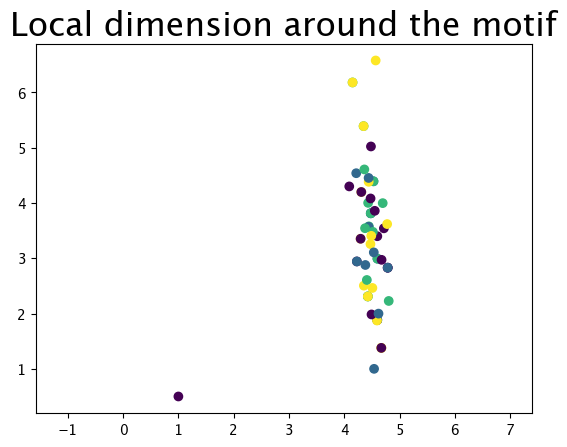

In [134]:
motif_emb = pp.transform([motif], layer=6)[0]
motif_loc_hom = []
for i in range(len(proteins)):
    kn_lh = KNeighborsLocalVietorisRips(n_neighbors=(5, 15),
                                     homology_dimensions=(0, 1),
                                     collapse_edges=True,
                                     n_jobs=-1)
    sequence_emb = list_of_model_outputs[i]
    kn_lh.fit(sequence_emb)
    motif_loc_hom.append(mod_pe.fit_transform(kn_lh.transform(motif_emb))[0])

motif_loc_hom = np.array(motif_loc_hom)

colors = [i%4 for i in range(len(motif_loc_hom))]
plt.scatter(motif_loc_hom[:, 0], motif_loc_hom[:, 1], c = colors)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Local dimension around the motif', fontsize=24)


## Conclusion
The method seems possible for protein sequences. However, it is difficult to tell with small scale experiements if ti will work in general. In particular, the function of the motif (in yellow) is supposed to have very varying local dimensions, whereas the other classes should be more clustered together. A lot more work is needed: especially, systematising the anylsis, finding the proper vectorisation of local homology, and interpeting the above plot in terms of protein sequences and dimensionality of the embedding manifold. We really hope that this notebook will pique your interests and suggest new relevant research directions for you. If you have feedback or helpful suggestions on this, it is always appreciated. If you have a simple interpretation of the results, please share!